In [52]:
%matplotlib inline

import os; os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Flatten, Reshape, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [3]:
tokenizer = Tokenizer(lower=False)

texts = ['Hello there I how are you?', 'I am doing ok', 'Well WELL well, how about that']
tokenizer.fit_on_texts(texts)
tokenizer.texts_to_sequences(texts)

[[14, 9, 1, 2, 12, 13], [1, 10, 8, 5], [7, 11, 3, 2, 4, 6]]

In [4]:
# load the dataset, only keeping top n words...already tokenized
n_top_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=n_top_words)

In [5]:
embedding_length = 32  # Destination length of embedding seq
max_review_length = 256  # Limit the review to this length

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length, padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length, padding='post')

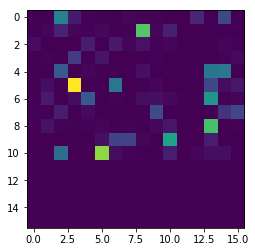

In [6]:
plt.imshow(X_train[np.random.randint(0, X_train.shape[0])].reshape((16, 16)))
plt.show()

In [85]:
# Encoding layers
embedding_length = 8

input_data = Input(shape=(max_review_length,))
#encoded = Embedding(n_top_words, embedding_length, input_length=max_review_length, mask_zero=True)(input_data)
encoded = Reshape((1, max_review_length))(input_data)
encoded = GRU(512)(encoded)
#encoded = Dense(512, activation='sigmoid')(input_data)
encoded = Dense(512, activation='relu')(encoded)

encoder = Model(input_data, encoded)  # Holds the layers that autoencoder trains

# Decoding layers
decoded = Dense(512, activation='relu')(encoded)
decoded = Reshape((1, 512))(decoded)
decoded = GRU(512)(decoded)
decoded = Dense(max_review_length, activation='relu')(decoded)


# Model definition
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='rmsprop', loss='poisson')

print(autoencoder.summary())

history = autoencoder.fit(X_train, X_train,
                          epochs=10,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 256)               0         
_________________________________________________________________
reshape_39 (Reshape)         (None, 1, 256)            0         
_________________________________________________________________
gru_39 (GRU)                 (None, 512)               1181184   
_________________________________________________________________
dense_226 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_227 (Dense)            (None, 512)               262656    
_________________________________________________________________
reshape_40 (Reshape)         (None, 1, 512)            0         
_________________________________________________________________
gru_40 (GRU)                 (None, 512)               1574400   
__________

In [17]:
# Encoding layers
input_data = Input(shape=(max_review_length,))
encoded = Embedding(n_top_words, embedding_length, input_length=max_review_length)(input_data)
encoded = LSTM(128)(encoded)
encoded = Dense(128, activation='sigmoid')(encoded)
encoded = Dense(128, activation='sigmoid')(encoded)

encoder = Model(input_data, encoded)  # Holds the layers that autoencoder trains

# Decoding layers
decoded = Dense(128, activation='sigmoid')(encoded)
decoded = Dense(128, activation='sigmoid')(decoded)
decoded = Reshape((1, 128))(decoded)
decoded = LSTM(max_review_length, return_sequences=True)(decoded)
decoded = LSTM(max_review_length)(decoded)

# Model definition
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='sgd', loss='binary_crossentropy')

print(autoencoder.summary())

history = autoencoder.fit(X_train, X_train,
                          epochs=10,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 256, 32)           320000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
__________

KeyboardInterrupt: 

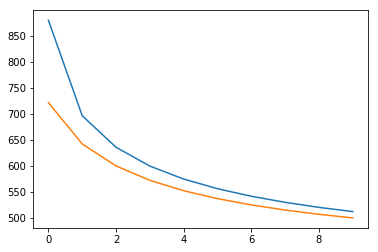

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [82]:
km = KMeans(n_clusters=2)
encoded_vals = encoder.predict(X_train)
p = km.fit_predict(encoded_vals)

In [83]:
print(classification_report(y_train, p, labels=[False, True]))

             precision    recall  f1-score   support

      False       0.50      0.46      0.48     12500
       True       0.50      0.55      0.53     12500

avg / total       0.50      0.50      0.50     25000



In [84]:
np.where(p == 1)[0].shape, np.where(y_train == 1)[0].shape

((13651,), (12500,))

(12500,)

In [77]:
# Layers
input_data = Input(batch_shape=(1, max_review_length))
x = Embedding(n_top_words, embedding_length, input_length=max_review_length)(input_data)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128, return_sequences=False)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_data, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (1, 256)                  0         
_________________________________________________________________
embedding_22 (Embedding)     (1, 256, 32)              320000    
_________________________________________________________________
lstm_15 (LSTM)               (1, 256, 100)             53200     
_________________________________________________________________
lstm_16 (LSTM)               (1, 100)                  80400     
_________________________________________________________________
dense_6 (Dense)              (1, 1)                    101       
Total params: 453,701
Trainable params: 453,701
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
np.expand_dims(X_train, axis=1).shape

(25000, 1, 256)

In [44]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Train on 25000 samples, validate on 25000 samples
Epoch 1/3


KeyboardInterrupt: 